# Exploratory Data Analysis of the **CBIS-DDSM** Dataset
## CBIS-DDSM Dataset

Developed in 1997 through a grant from the DOD Breast Cancer Research Program and the US Army Research and Material Command, the *original* Digital Database for Screening Mammography (DDSM) {cite}`USFDigitalMammography` is a collection of 2620 cases obtained by patient consent from Massachusetts General Hospital, Wake Forest University School of Medicine, Sacred Heart Hospital, and Washington University of St. Louis School of Medicine. Its cases are annotated with ROIs for calcifications and masses, they include Breast Imaging Reporting and Data System (BI-RADS) descriptors for mass shape, mass margin, calcification type, calcification distribution, and breast density. They also include overall BI-RADS assessments from 0 to 5 and ratings of the subtlety of the abnormalities from 1 to 5.

The DDSM, a powerful and extensively used resource for imaging research, presented certain challenges that limited its accessibility and utility.  For instance, the original DDSM was saved in lossless JPEG files (LJPEG); a non-standard, and obsolete compression format. Regions of interest marked the general area of legions; but, lacked the specificity of precise image segmentation, requiring researchers to implement segmentation algorithms for accurate feature extraction. Some annotations marked legions that could not be seen. Further, the metadata processing and image correction routines distributed with the dataset were a set of bash and C routines that were difficult to refactor.
This Curated Breast Imaging Subset of DDSM (CBIS-DDSM) {cite}`leeCuratedMammographyData2017` is an updated and standardized version of the original DDSM, developed to address some of the challenges. In particular, the questionable annotations were reviewed by a trained mammographer, and 254 images were removed from the dataset. The images were converted from PVRG-JPEG to 8-bit raw binary bitmaps. Python tools were developed to convert the 8-bit images to 16-bit grayscale TIFF files, which were later converted to DICOM. The bash and C preprocessing tools were re-implemented in Python to be cross-platform. Convenience images were cropped around the region of interest for researchers analyzing only the abnormalities. Precise segmentation was applied to the calcification images providing much more accurate regions of interest, and the data were split into training and test sets, based on the BIRADS category to support method evaluation and reproducibility.

### Dataset Statistics
CBIS-DDSM was obtained from the Cancer Imaging Archive {cite}`sawyer-leeCuratedBreastImaging2016` and is summarized below:
```{table}
:name: cbis-ddsm-stats

| Collection Statistics  |        |
| ---------------------- | ------ |
| Image Size (GB)        | 163.6  |
| Modalities             | MG     |
| Number of Images       | 10239  |
| Number of Participants | 1,566* |
| Number of Series       | 6775   |
| Number of Studies      | 6775   |
```
The CBIS-DDSM data were split into training and test (20%), sets based on BI-RADS category. Splitting by abnormality type, 20% of the cases were allocated to the test sets and the remaining were designated for training.

```{table} Number of Cases and Abnormalities in the Training and Test Sets.
:name: dataset-splits

| Dataset                    | Benign Cases                  | Malignant Cases               |
|----------------------------|-------------------------------|-------------------------------|
| Calcification Training Set | 329 Cases (552 Abnormalities) | 273 Cases (304 Abnormalities) |
| Calcification Test Set     | 85 Cases (112 Abnormalities)  | 66 Cases (77 Abnormalities)   |
| Mass Training Set          | 355 Cases (387 Abnormalities) | 336 Cases (361 Abnormalities) |
| Mass Test Set              | 117 Cases (135 Abnormalities) | 83 Cases (87 Abnormalities)   |
```
### Dataset Organization
The following files contain the mammography and ROIs for the cases with calcifications.

| Type   | Filename                             | Format |
| ------ | ------------------------------------ | ------ |
| Images | Calc-Test Full Mammogram Images      | DICOM  |
| Images | Calc-Test ROI and Cropped Images     | DICOM  |
| Images | Calc-Training Full Mammogram Images  | DICOM  |
| Images | Calc-Training ROI and Cropped Images | DICOM  |

The following files contain the mammography and ROIs for the mass cases.

| Type   | Filename                             | Format |
| ------ | ------------------------------------ | ------ |
| Images | Mass-Test Full Mammogram Images      | DICOM  |
| Images | Mass-Test ROI and Cropped Images     | DICOM  |
| Images | Mass-Training Full Mammogram Images  | DICOM  |
| Images | Mass-Training ROI and Cropped Images | DICOM  |

There are separate metadata files for the train and test calcification and mass cases.

| Type     | Filename                  | Format |
| -------- | ------------------------- | ------ |
| Metadata | Calc-Test-Description     | csv    |
| Metadata | Calc-Training-Description | csv    |
| Metadata | Mass-Test-Description     | csv    |
| Metadata | Mass-Training-Description | csv    |

Metadata for each abnormality above contains:

- Patient ID: the first 7 characters of images in the case file
- Density category
- Breast: Left or Right
- View: CC or MLO
- Number of abnormality for the image (This is necessary as there are some cases containing multiple abnormalities.)
- Mass shape (when applicable)
- Mass margin (when applicable)
- Calcification type (when applicable)
- Calcification distribution (when applicable)
- BI-RADS assessment
- Pathology: Benign, Benign without call-back, or Malignant
- Subtlety rating: Radiologists’ rating of difficulty in viewing the abnormality in the image
- Path to image files

Note, the data are structured such that a single participant has multiple patient IDs, where each id corresponds to a scan.

In [1]:
import sys
import os
os.chdir(os.path.abspath(os.path.join("../..")))
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from PIL import Image
from bcd.data.dataset import CBISMeta
sns.set_style('whitegrid')
sns.set_palette("Blues_r")

We'll begin our exploration with questions to guide the process.

1. Density is considered a potential signal of pathology. How does density relate to pathology in the CBIS-DDSM dataset?
2. Does density and abnormality type relate?
3. What does density and abnormality type indicate w.r.t pathology?
4. Which abnormality type is most malignant in the dataset?
5. Which abnormality type is more subtle? 

Regarding Calcifications: 
1. What does density, calcification type and distribution imply about subtlety, and pathology?
2. How does calcification type relate to subtlety? pathology?
3. What does calcification distribution relate to subtlety, pathology?

For masses:
1. What does density, mass shape and margin imply about subtlety, and pathology?
2.  What does density and calcification type and distribution imply about subtlety, and pathology?
3.   How does mass shape relate to subtlety? pathology?
4.   How does mass margin relate to subtlety? pathology?


We'll approach the analysis in three stages:
1.  Train Dataset Analysis using combined training sets for calcification and mass cases.
2.  Calcification Case Analysis using the calcifiation training set.
3.  Mass Case Analysis using the mass training set.

## Training Dataset Analysis
This initial 

In [2]:
fp = "/home/john/projects/bcd/data/raw/meta/calc_case_description_train_set.csv"
df = pd.read_csv(fp)
ds = CBISMeta(df=df)

In [3]:
ds.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [4]:
ds.info

,Column,DataType,Valid,Null,Validity,Cardinality,Percent Unique,Size
0,patient_id,object,1546,0,1.00,602,0.39,98944
1,breast density,int64,1546,0,1.00,4,0.00,12368
2,left or right breast,object,1546,0,1.00,2,0.00,95034
3,image view,object,1546,0,1.00,2,0.00,92021
4,abnormality id,int64,1546,0,1.00,7,0.00,12368
5,abnormality type,object,1546,0,1.00,1,0.00,108220
6,calc type,object,1526,20,0.99,45,0.03,109176
7,calc distribution,object,1170,376,0.76,9,0.01,89521
8,assessment,int64,1546,0,1.00,5,0.00,12368
9,pathology,object,1546,0,1.00,3,0.00,107088


**Initial observations:**
1. We have 1546 calcification images in the dataset.
2. There 602 unique patient ids in which multiple patient ids per patient are extant.
3. With the exception of calcification type and distribution, we have no null values.
4. There are 45 calcification types and 9 calcification distribution values.
5. There is some duplication in the image file path, which should be addressed.

### Univariate Analysis

#### Patient Id

In [5]:
print(f"The total number of unique ids {df['patient_id'].nunique()}.")
print(f"The median number of images per patient id is {df['patient_id'].value_counts().median()}")
print(f"The average number of images per patient id is {round(df['patient_id'].value_counts().mean(),2)}")
print(f"The range of images to patient_ids is {df['patient_id'].value_counts().min()} to {df['patient_id'].value_counts().max()} ")

The total number of unique ids 602.
The median number of images per patient id is 2.0
The average number of images per patient id is 2.57
The range of images to patient_ids is 1 to 24 


#### Breast Density
Radiologists classify breast density using a 4-level density scale {cite}`BreastImagingReporting`:
1.	Almost entirely fatty
2.	Scattered areas of fibroglandular density
3.	Heterogeneously dense
4.	Extremely dense

According to the American College of Radiology (ACR), the distribution of breast density in the U.S.     


In [49]:
breast_density_counts = df['breast density'].value_counts(normalize=False, sort=False).to_frame().sort_index()
breast_density_counts['Sample'] = 'CBIS-DDSM'
us_counts = [.10* breast_density_counts['count'].sum(), .4*breast_density_counts['count'].sum(), .4*breast_density_counts['count'].sum(), .1*breast_density_counts['count'].sum()]
us_counts = pd.DataFrame(us_counts, index=[0,1,2,3])
us_counts["Sample"] = 'U.S.'
us_counts.columns = ['count', 'Sample']
us_counts
us_counts.index = [1,2,3,4]
counts = pd.concat([breast_density_counts, us_counts], axis=0)
counts = counts.reset_index()
counts.columns = ['Breast Density', 'Count', 'Sample']
counts

,count,Sample
0,154.60,U.S.
1,618.40,U.S.
2,618.40,U.S.
3,154.60,U.S.


,Breast Density,Count,Sample
0,1,175.00,CBIS-DDSM
1,2,501.00,CBIS-DDSM
2,3,539.00,CBIS-DDSM
3,4,331.00,CBIS-DDSM
4,1,154.60,U.S.
5,2,618.40,U.S.
6,3,618.40,U.S.
7,4,154.60,U.S.


TypeError: pie() got an unexpected keyword argument 'ax'

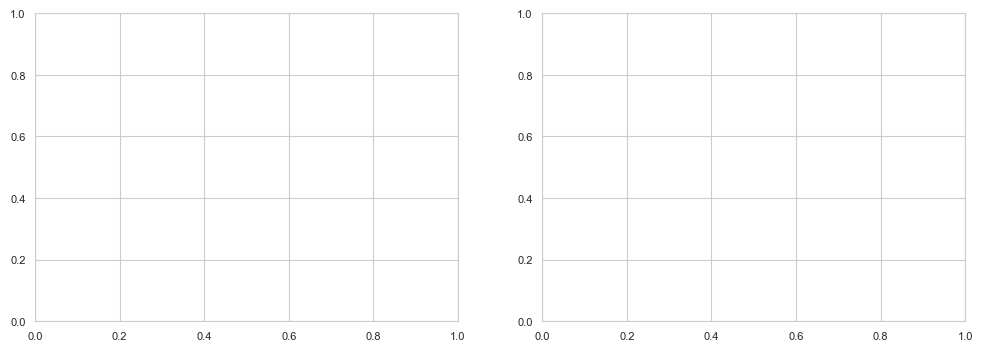

In [29]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
dataCBIS = [175,501,539,331]
dataUS = [10,40,40,10]
keys = ['Almost Entirely Fatty','Scattered Areas of \nFibroglandular Density', 'Heterogeneously Dense', 'Extremely Dense']
palette_color = sns.color_palette('Blues_r')
ax1.pie(dataUS, labels=keys, colors=palette_color, autopct='%.0f%%', ax=ax1)
ax2 = plt.pie(dataCBIS, labels=keys, colors=palette_color, autopct='%.0f%%', ax=ax2)
ax1.set_title("Breast Density in the U.S.")
ax1.set_title("Breast Density in CBIS-DDSM.")
#plt.show()

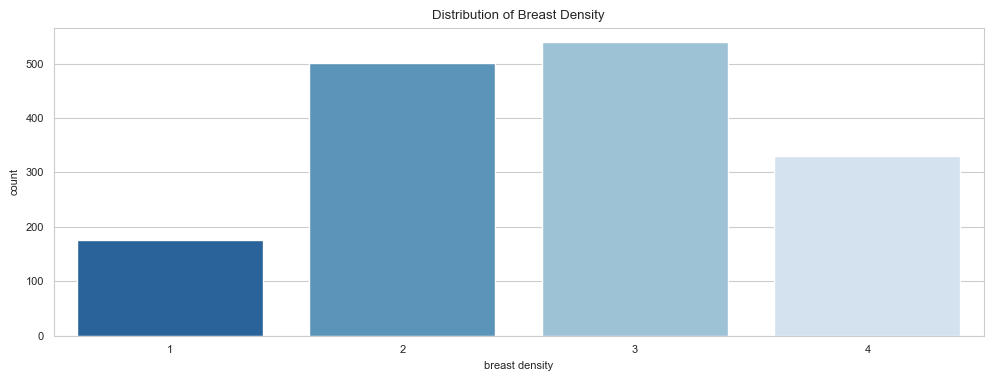

In [6]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(data=countsx='breast density', ax=ax, title ="Distribution of Breast Density in CBIS-DDSM Calcification Cases")

#### Left Right

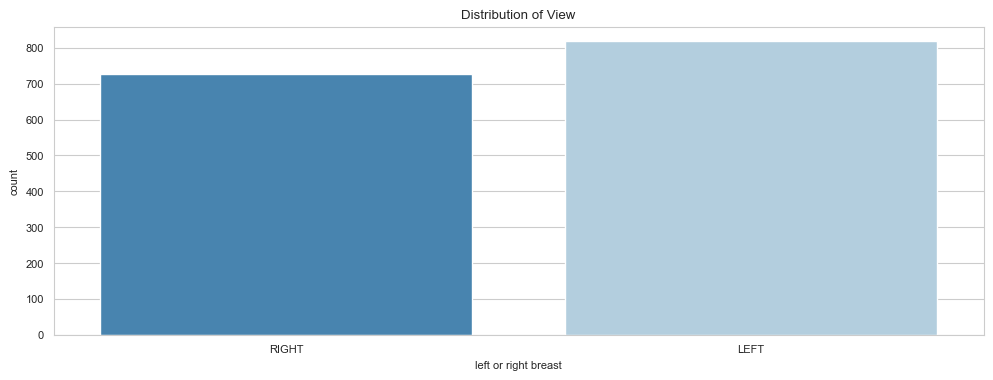

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='left or right breast', ax=ax, title ="Distribution of View")

#### Image View

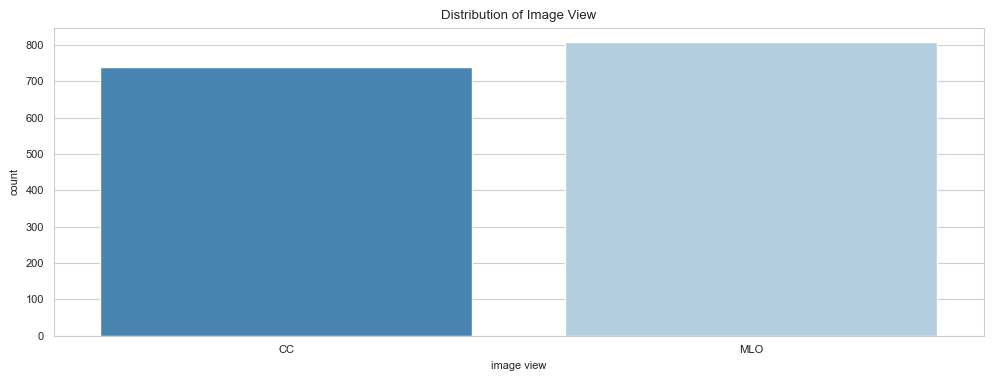

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='image view', ax=ax, title ="Distribution of Image View")

#### Abnormality Id

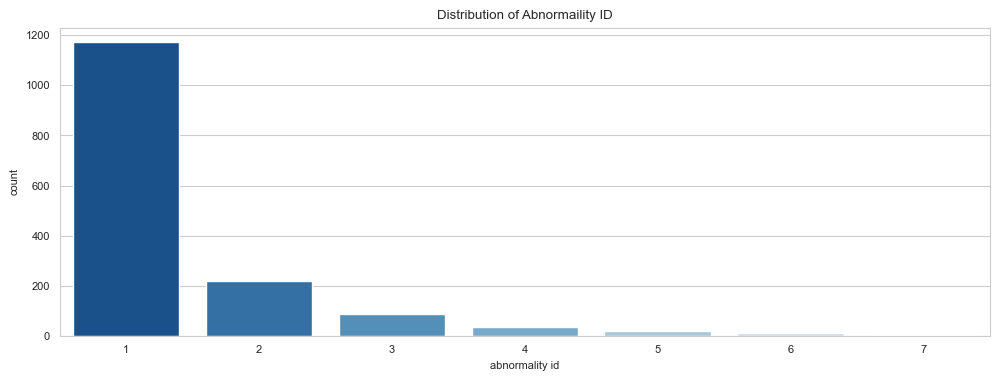

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='abnormality id', ax=ax, title ="Distribution of Abnormaility ID")

Most patients have only one abnormality.

#### Calcification Type

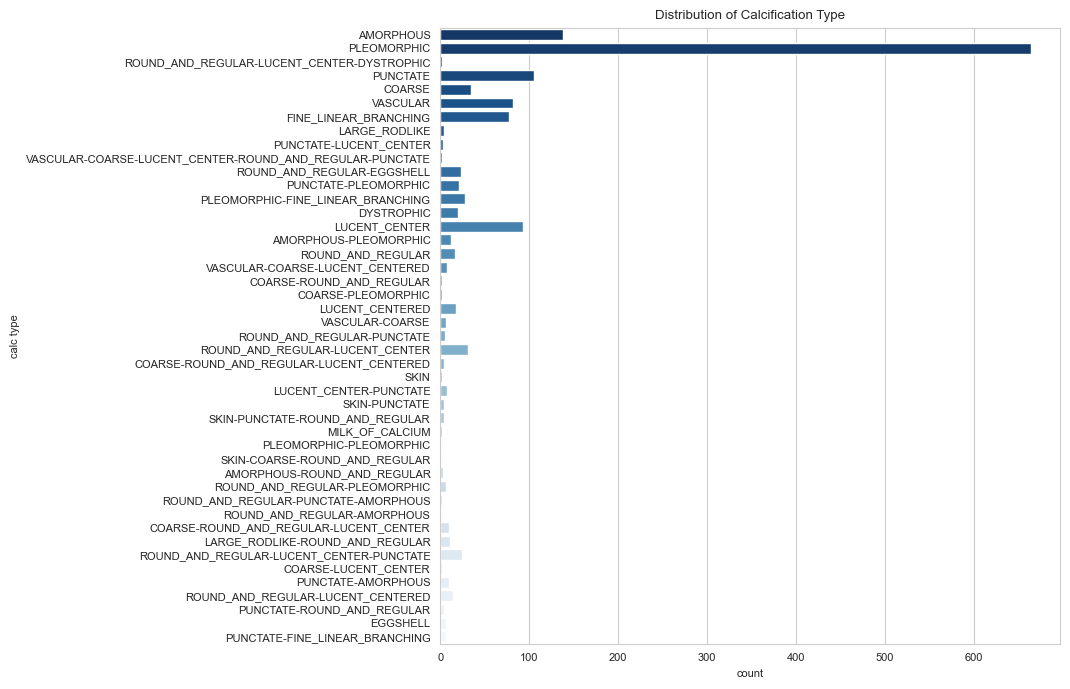

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
ds.plot.countplot(y='calc type', ax=ax, title ="Distribution of Calcification Type")

#### Calcification Distribution

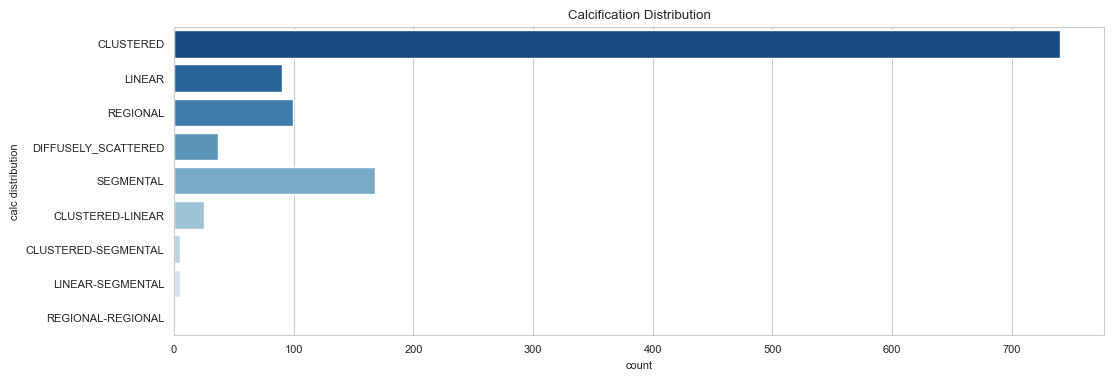

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(y='calc distribution', ax=ax, title ="Calcification Distribution")

#### BIRADS Assessment

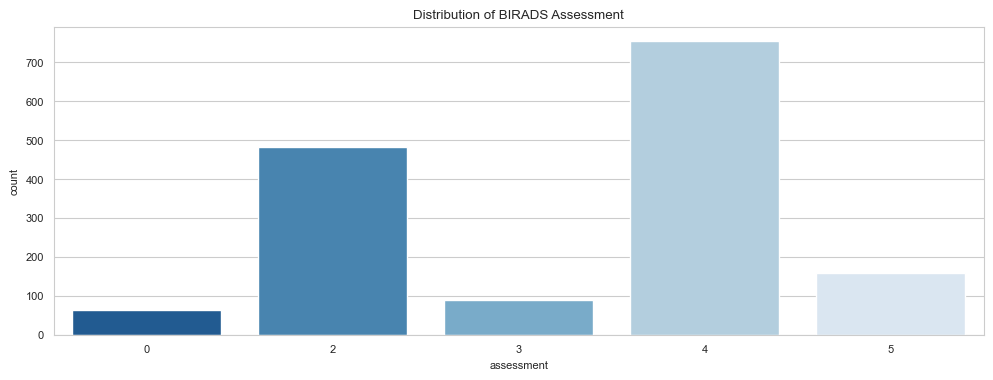

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='assessment', ax=ax, title ="Distribution of BIRADS Assessment")

#### Pathology

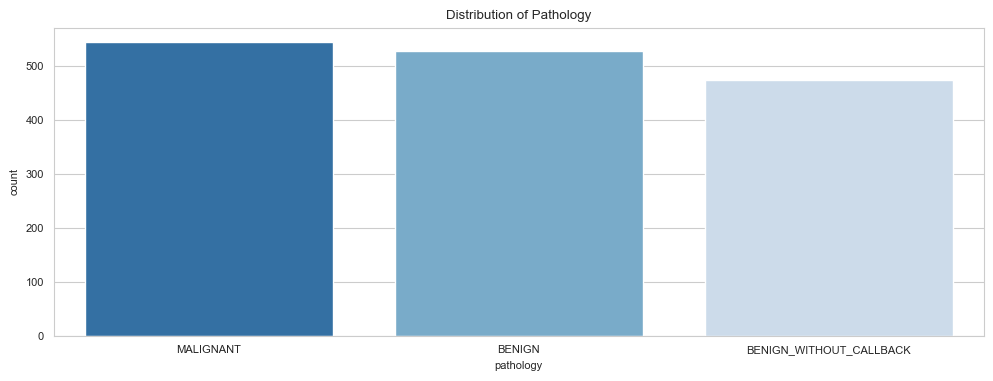

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='pathology', ax=ax, title ="Distribution of Pathology")

#### Sublety

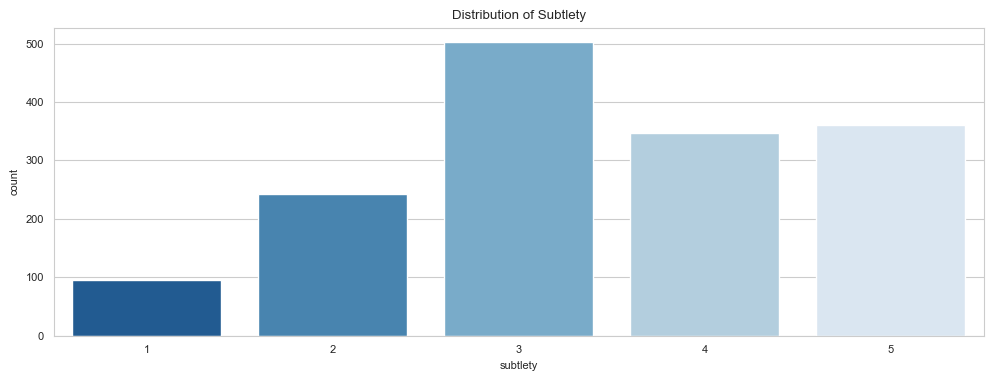

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='subtlety', ax=ax, title ="Distribution of Subtlety")

### Bivariate Analysis
At this stage, we are examining bivariate relationships between the variables and between the variables and the target, pathology. 

#### Density Analysis
Here, we'll explore how breast density relates to pathology, calcification type and distribution, assessment, and subtlety.


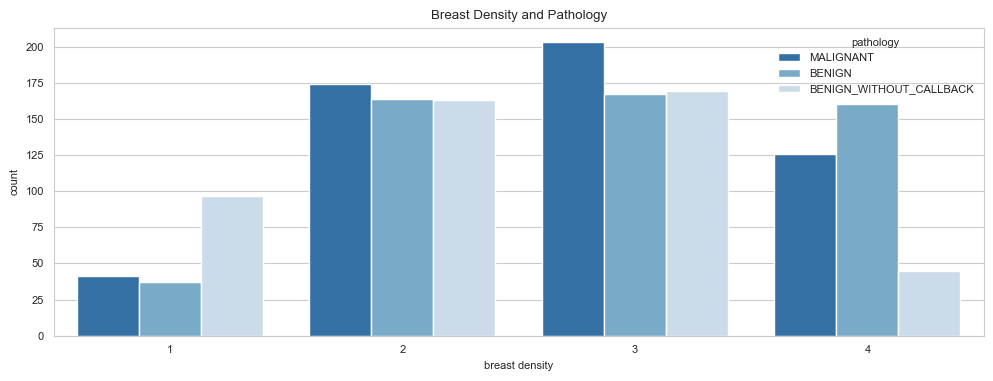

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='breast density', hue='pathology'   , ax=ax, title ="Breast Density and Pathology")

In [17]:
ds.describe(x=['breast density', 'pathology'], groupby='breast density').categorical

pathology                                     
                   count unique                      top freq
breast density                                               
1                    175      3  BENIGN_WITHOUT_CALLBACK   97
2                    501      3                MALIGNANT  174
3                    539      3                MALIGNANT  203
4                    331      3                   BENIGN  160

**Key Observations**
1. Lower density abnormalities were associated with a greater number of benign, without callback. This is not unexpected as greater density is typically associated with greater scrutiny.
2. Level 2 density typically indicates scattered areas of fibroglandular density, but the majority of tissue is non-dense. In this level 2 (or B), the vast majority of cases were benign, but the proportion of malignant cases appears to be increasing.
3. Level 3 density typically indicates some areas of nondense tissue, but most areas are dense. Here too, the majority of cases were benign; however, the proportion of malignant cases increased from level 2.
4. In contrast to level 1 density, there are fewer benign without callback cases. This indicates a greater degree of suspicion with these patients.
